Summarizing the number of variants per tr-region

In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("../tables/per_region_varcount.txt.gz", sep='\t')
data['key'] = data[['chrom', 'start', 'end']].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
data.set_index('key', inplace=True)

In [3]:
data.head()

,chrom,start,end,adotto_tot,adotto_5bp,thfa_tot,thfa_5bp
key,,,,,,,
chr1_16682_16774,chr1,16682,16774,0,0,0,0
chr1_19275_19473,chr1,19275,19473,0,0,0,0
chr1_20798_20893,chr1,20798,20893,0,0,0,0
chr1_29714_29822,chr1,29714,29822,0,0,0,0
chr1_30824_30989,chr1,30824,30989,0,0,0,0


In [4]:
any_hg002 = (data['adotto_tot'] != 0) | (data['thfa_tot'] != 0)
print(len(data[any_hg002]), "regions with any HG002 variant")

546777 regions with any HG002 variant


In [5]:
any_5bp_hg002 = (data['adotto_5bp'] != 0) | (data['thfa_5bp'] != 0)
print(len(data[any_5bp_hg002]), "regions with any HG002 variant >= 5bp")

147952 regions with any HG002 variant >= 5bp


In [6]:
adotto_not_thfa = data[any_5bp_hg002]['thfa_5bp'] == 0
thfa_not_adotto = data[any_5bp_hg002]['adotto_5bp'] == 0
# Present in both but don't agree in how many
disagreement =  ~adotto_not_thfa & ~thfa_not_adotto & (data[any_5bp_hg002]['adotto_5bp'] != data[any_5bp_hg002]['thfa_5bp'])

In [7]:
print(adotto_not_thfa.value_counts())
print(adotto_not_thfa.mean())

False    142566
True       5386
Name: thfa_5bp, dtype: int64
0.03640369849680978


In [8]:
print(thfa_not_adotto.value_counts())
print(thfa_not_adotto.mean())

False    142209
True       5743
Name: adotto_5bp, dtype: int64
0.038816643235643995


In [9]:
print(disagreement.value_counts())
print(disagreement.mean())

False    135997
True      11955
dtype: int64
0.08080323348112901


In [10]:
all_troublesome = disagreement | adotto_not_thfa | thfa_not_adotto
print(all_troublesome.value_counts())
print(all_troublesome.mean())

False    124868
True      23084
dtype: int64
0.1560235752135828


For no good reason, let's just throw out the troublesome regions. For the remaining ones, lets get an idea for how many regions the truthsets give the same answer. These are likely the easiest regions to resolve.

In [11]:
filtered_data = data[any_5bp_hg002 & data.index.isin(all_troublesome[~all_troublesome].index)]

In [12]:
len(filtered_data)

124868

In [13]:
filtered_data

,chrom,start,end,adotto_tot,adotto_5bp,thfa_tot,thfa_5bp
key,,,,,,,
chr1_839268_839680,chr1,839268,839680,4,1,4,1
chr1_853385_853936,chr1,853385,853936,10,1,10,1
chr1_860153_860236,chr1,860153,860236,1,1,1,1
chr1_866415_867223,chr1,866415,867223,7,2,7,2
chr1_908556_908882,chr1,908556,908882,2,1,2,1
...,...,...,...,...,...,...,...
chrX_155830829_155830930,chrX,155830829,155830930,2,1,2,1
chrX_155846289_155846354,chrX,155846289,155846354,1,1,1,1
chrX_155848549_155848660,chrX,155848549,155848660,2,2,2,2


So now I could rerun bench on discovery sets and these regions and would hopefully get identical answers from both base vcfs?

AND! We're going to call these 'ranks' and number them with lower rank meaning less-likely to have ambiguous representations. 

In [14]:
filtered_data[['chrom', 'start', 'end']].to_csv("rank1.bed", sep='\t', header=False, index=False)

Okay, so I realized I need to make a rank0 - these are all the TRregions where HG002 has a call (in either VCF)

In [15]:
data[any_5bp_hg002][['chrom', 'start', 'end']].to_csv("rank0.bed", sep='\t', header=False, index=False)

* We have a total of N regions in our TR catalog
* We are going to classify the regions into different ranks
  * Higher the rank, the harder it is to compare.
  * These ranks should be highly correlated with traditional GIAB Tiers
* HG002 Superset - N regions have any HG002 variant in Adotto or THFA
* Rank5: N regions have any variant <5bp in Adotto or THFA
* Rank4: N regions have any variant >=5bp in Adotto or THFA
* Rank3: N regions have any variant >=5bp in Adotto AND THFA
* Rank2: N regions SAME NUMBER of >=5bp in Adotto and THFA
* Rank1: N regions have only MATCHING >=5bp variants between Adotto and THFA
* Rank0: N regions have only MATCHING >=5bp variants between Adotta and THFA as well as at least 1 `truvari anno trf` reference annotation matching variant


In [16]:
superset = any_hg002
rank4_all = any_5bp_hg002
rank3_all = (data['adotto_5bp'] != 0) & (data['thfa_5bp'] != 0)
rank2_all = ((data['adotto_5bp'] != 0) & (data['thfa_5bp'] != 0)) & (data['adotto_5bp'] == data['thfa_5bp'])

# Get the exclusive sets
rank4_exclusive = rank4_all & ~rank3_all & ~rank2_all
rank3_exclusive = rank3_all & ~rank2_all
rank2_exclusive = rank2_all
rank5_exclusive = superset & ~rank4_exclusive & ~rank3_exclusive & ~rank2_exclusive

In [17]:
# Make a region count table
table = [["total", len(data)],
         ["superset", any_hg002.value_counts()[True]],
         ["rank5", rank5_exclusive.value_counts()[True]],
         ["rank4", rank4_exclusive.value_counts()[True]],
         ["rank3", rank3_exclusive.value_counts()[True]]]
rank_table = pd.DataFrame(table, columns=["set", "count"])
rank_table.set_index("set", inplace=True)
rank_table      

,count
set,
total,938088
superset,546777
rank5,398825
rank4,11129
rank3,11955


In [18]:
# Save all the ranks
# then take rank2 and use the intersection to figure out what is rank1 vs rank0
data[rank2_exclusive][["chrom", "start", "end"]].to_csv("rank2.bed", sep='\t', header=False, index=False)

In [19]:
rank2_benchcounts = pd.read_csv("../tables/rank2_benchcounts.txt.gz", sep='\t')
rank2_benchcounts['key'] = rank2_benchcounts[['chrom', 'start', 'end']].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
rank2_benchcounts.set_index('key', inplace=True)

In [20]:
rank1_all = (rank2_benchcounts['fp'] == 0) & (rank2_benchcounts['fn'] == 0)
rank0_exclusive = rank1_all & ((rank2_benchcounts['tpb_tat'] != 0) | (rank2_benchcounts['tp_tat'] != 0))
rank1_exclusive = rank1_all & ~rank0_exclusive
rank2_exclusive = ~rank1_exclusive & ~rank0_exclusive

In [21]:
rank_table.loc['rank2', 'count'] = rank2_exclusive.value_counts()[True]
rank_table.loc['rank1', 'count'] = rank1_exclusive.value_counts()[True]
rank_table.loc['rank0', 'count'] = rank0_exclusive.value_counts()[True]

rank_table["percent"] = rank_table["count"] / rank_table.loc["total", "count"]

In [22]:
rank_table

,count,percent
set,,
total,938088.0,1.000000
superset,546777.0,0.582863
rank5,398825.0,0.425147
rank4,11129.0,0.011863
rank3,11955.0,0.012744
rank2,4713.0,0.005024
rank1,3660.0,0.003902
rank0,116495.0,0.124183


In [23]:
#Okay. Now I need to put these ranks back into the full data so I can separate them out
# Just a single bed with region-->rank

In [24]:
[len(rank5_exclusive),
len(rank4_exclusive),
len(rank3_exclusive),
len(rank2_exclusive),
len(rank1_exclusive),
 len(rank0_exclusive)]

[938088, 938088, 938088, 124868, 124868, 124868]

In [25]:
len(rank2_benchcounts)

124868

In [26]:
data['rank'] = None

In [33]:
m_data = data.copy()#data.loc[rank5_exclusive, 'rank'] = 5

In [34]:
m_data.loc[rank5_exclusive[rank5_exclusive].index, 'rank'] = 5
m_data.loc[rank4_exclusive[rank4_exclusive].index, 'rank'] = 4
m_data.loc[rank3_exclusive[rank3_exclusive].index, 'rank'] = 3
m_data.loc[rank2_exclusive[rank2_exclusive].index, 'rank'] = 2
m_data.loc[rank1_exclusive[rank1_exclusive].index, 'rank'] = 1
m_data.loc[rank0_exclusive[rank0_exclusive].index, 'rank'] = 0

In [37]:
m_data['rank'].value_counts(dropna=False)

5.0    398825
NaN    391311
0.0    116495
3.0     11955
4.0     11129
2.0      4713
1.0      3660
Name: rank, dtype: int64

In [39]:
m_data[["chrom", "start", "end", "rank"]].to_csv("hg002_trregion_ranks.bed", sep='\t', header=False, index=False)

In [45]:
view = m_data.groupby(['chrom', 'rank']).size().unstack().reset_index().melt(id_vars='chrom', value_name="region_count")

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 [Text(0, 0, 'chr1'),
  Text(1, 0, 'chr10'),
  Text(2, 0, 'chr11'),
  Text(3, 0, 'chr12'),
  Text(4, 0, 'chr13'),
  Text(5, 0, 'chr14'),
  Text(6, 0, 'chr15'),
  Text(7, 0, 'chr16'),
  Text(8, 0, 'chr17'),
  Text(9, 0, 'chr18'),
  Text(10, 0, 'chr19'),
  Text(11, 0, 'chr2'),
  Text(12, 0, 'chr20'),
  Text(13, 0, 'chr21'),
  Text(14, 0, 'chr22'),
  Text(15, 0, 'chr3'),
  Text(16, 0, 'chr4'),
  Text(17, 0, 'chr5'),
  Text(18, 0, 'chr6'),
  Text(19, 0, 'chr7'),
  Text(20, 0, 'chr8'),
  Text(21, 0, 'chr9'),
  Text(22, 0, 'chrX'),
  Text(23, 0, 'chrY')])

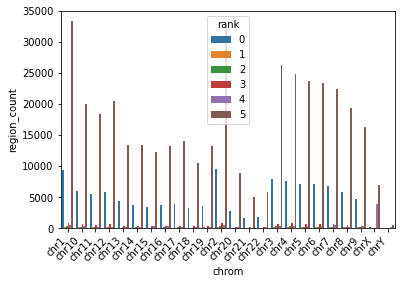

In [47]:
sb.barplot(data=view, x="chrom", y="region_count", hue="rank")
plt.xticks(rotation=45, ha='right')

In [48]:
m_data['span'] = m_data['end'] - m_data['start']

In [54]:
a = m_data.groupby(['rank'])['span'].sum() / 3.2e9
b = m_data.groupby(['rank']).size()
x = pd.concat([a, b], axis=1)
x.columns = ['genome%', 'count']

In [55]:
x

,genome%,count
rank,,
0,0.006027,116495
1,0.000407,3660
2,0.000358,4713
3,0.001893,11955
4,0.001159,11129
5,0.014824,398825
